In [1]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
%matplotlib inline

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
multiplier = 20
min_tick = 0.25

In [3]:
periods = [5, 10, 20, 40, 80] #, 160, 320] # 320] # number of periods for breakout rule
ema_fast = 120 # number of periods for moving average filter
sl_atr = 1 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 30 # interval in minutes to be used to define volume candle

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

9916.21218117854

In [5]:
#vol_candles = group_by_time(contract, time_int)
vol_candles = group_by_volume(contract, avg_vol)
data = pd.DataFrame(vol_candles.close)
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()

In [6]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

In [7]:
def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).apply(np.floor)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
  

In [8]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

In [9]:
signals['value'] = signals['close'] * signals['signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

In [10]:
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, atr_periods)

In [11]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * sl_atr
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [12]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [13]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(8492.75, 6453.75, 14946.5)

In [14]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(8356, 7163, 0.5384367549455507)

In [15]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(73982.75, -59036.25, 1.2531749560651295)

In [16]:
pnl_m.sort_values().head(20)

label
5073    -97.00
5045    -76.50
14799   -74.25
5429    -73.25
22364   -64.50
12261   -63.00
22472   -58.25
5084    -57.50
5092    -57.00
13902   -56.00
5077    -54.25
9964    -54.25
5065    -52.25
15425   -49.75
12165   -48.75
5268    -47.00
13476   -46.25
5321    -46.00
6775    -45.25
15643   -45.00
Name: pnl, dtype: float64

In [17]:
pnl_p.sort_values(ascending=False).head(20)

label
14798    180.00
14653    118.25
5068     111.25
23464    108.25
21588     95.25
5044      70.75
22616     58.50
5052      54.25
5204      51.75
22362     50.75
5252      49.75
13007     49.00
19496     48.75
20323     47.50
5048      45.75
7849      45.25
5079      45.25
12164     45.00
5308      44.75
14811     44.25
Name: pnl, dtype: float64

In [18]:
signals['date'] = vol_candles['date']

In [19]:
signals.set_index('date', inplace=True)

In [20]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-08-31,NaN,0.00
2019-09-01,NaN,0.00
2019-09-02,7618.00,-32.25
2019-09-03,7614.50,-7.75
2019-09-04,7697.25,40.00


In [21]:
daily.head()

,close,pnl
date,,
2017-05-25,5754.5,0.0
2017-05-26,NaN,0.0
2017-05-27,NaN,0.0
2017-05-28,NaN,0.0
2017-05-29,NaN,0.0


In [22]:
daily['dollars'] = 0
daily.iloc[0,2] = 15000

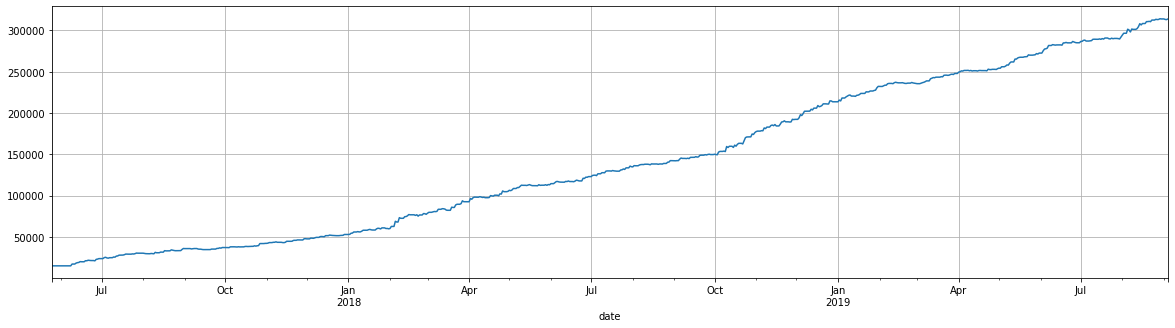

In [23]:
daily['dollars'] = 15000 + daily.pnl.cumsum() * multiplier
daily['return'] = daily.dollars.pct_change()
daily.dollars.plot(figsize=(20,5), grid=True);

In [24]:
daily['absolute'] = daily['pnl'] * multiplier/10000

In [25]:
perf_stats(daily['absolute'].iloc[40:])

Annual return          3.061411e+03
Cumulative returns     9.333253e+10
Annual volatility      1.534986e+00
Sharpe ratio           5.981990e+00
Calmar ratio           9.805143e+03
Stability              9.835172e-01
Max drawdown          -3.122250e-01
Omega ratio            4.406626e+00
Sortino ratio          2.082347e+01
Skew                   2.009163e+00
Kurtosis               6.067874e+00
Tail ratio             3.573209e+00
Daily value at risk   -1.569524e-01
dtype: float64

In [26]:
perf_stats(daily['return'].iloc[40:])

Annual return           1.235204
Cumulative returns     11.567254
Annual volatility       0.160653
Sharpe ratio            5.092950
Calmar ratio           28.893537
Stability               0.962953
Max drawdown           -0.042750
Omega ratio             4.113487
Sortino ratio          17.768379
Skew                    3.248795
Kurtosis               18.899368
Tail ratio              3.342449
Daily value at risk    -0.016994
dtype: float64

In [27]:
number_of_trades

1559

In [28]:
spread = min_tick * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

10959.769999999999

In [29]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

832

In [30]:
trades_per_day = number_of_trades / days
trades_per_day

1.8737980769230769

In [31]:
pnl_in_dollars = pnl*multiplier

In [32]:
cost_of_trades / (pnl_in_dollars)

0.03666333255277155

In [33]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(0.9407628421071693, 0.19328711301526577)

In [34]:
mean/std

4.867178299842825

In [35]:
#daily.to_pickle('nq_return.pickle')